<a href="https://colab.research.google.com/github/Nidhi-1223/Dog-Vision/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle_api'

Link to the [data](https://www.kaggle.com/competitions/dog-breed-identification/data)

In [ ]:
# #importing the data through kaggle api
# !kaggle competitions download -c dog-breed-identification
# #this wont upload the data into google drive. But i have dragged and dropped it into the drive for now

In [ ]:
# !unzip /content/drive/MyDrive/dog-vision/dog-breed-identification.zip -d '/content/drive/MyDrive/dog-vision/'

In [ ]:
!pwd

/content


# End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using Tensorflow and Tensor-flow hub

## 1. Problem Statement

Identifying the breed of a dog, given an image

## 2. Data

Data is taken from Kaggle's dog breed identification competition.
[Link](https://www.kaggle.com/competitions/dog-breed-identification/data)

## 3. Evaluation

Submissions are evaluated on `Multi Class Log Loss` between the predicted probability and the observed target.
The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

Some information about the data :
* We're dealing with images (unstructured data) so it's probably best we use Deep Learning / transfer learning. 
* There are 120 breeds of dogs (this means there are 120 different classes)
* There are around 10,000+ images in the training set (these images have labels)
* There are around 10,000+ images in the test set (these images don't have labels)

## Getting our workspace ready

In [ ]:
import tensorflow as tf
print('TF version: ', tf.__version__)

TF version:  2.9.2


In [ ]:
import tensorflow_hub as hub
print('TF Hub version : ', hub.__version__)

TF Hub version :  0.12.0


In [ ]:
#check for gpu availability
print('GPU', 'Available (YESSSS!!)' if tf.config.list_physical_devices('GPU') else 'Not available :(' )

GPU Available (YESSSS!!)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

## Turning our data into Tensors
For all machine learning models, our data has to be in numerical format. So we'll turn our images into tensors (numerical representation)

Let's start by taking a look at the labels

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/dog-vision/labels.csv')
labels.head(20)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [ ]:
labels.shape

(10222, 2)

In [ ]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In `.describe()` , `freq` is the number of times the `top` element was seen. 
So here, `scottish_deerhound` was seen `126` times.

In [ ]:
126 * 120 #idk

15120

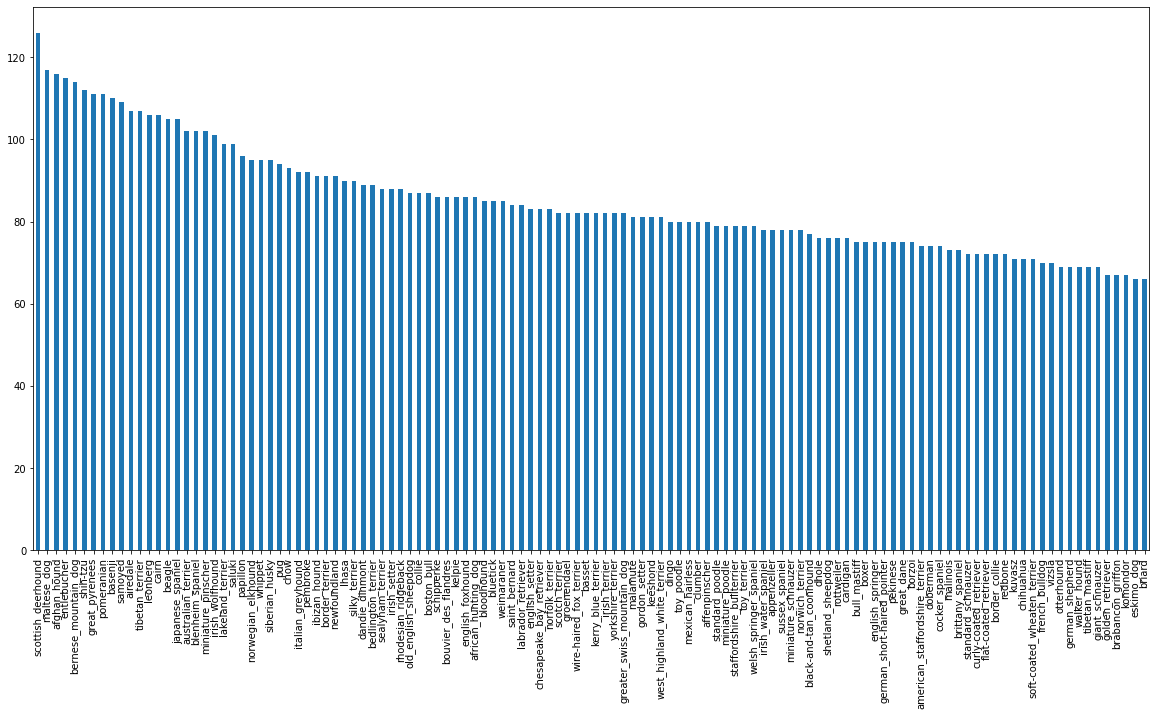

In [ ]:
#figure out how many images we have per class (per breed)
labels['breed'].value_counts().plot.bar(figsize=(20,10))

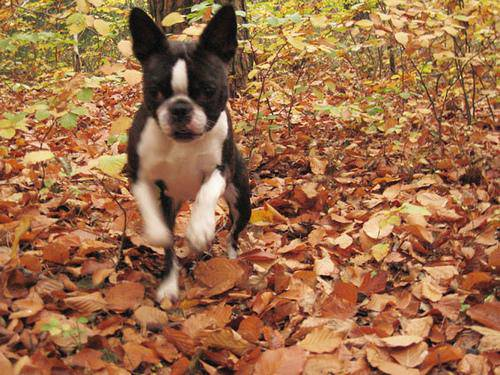

In [ ]:
#let's view an image
from IPython.display import Image
Image('/content/drive/MyDrive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

In [ ]:
# a way of parsing through filenames:
filename = ['/content/drive/MyDrive/dog-vision/train/' + fname + '.jpg' for fname in labels['id']]
filename[:10]

['/content/drive/MyDrive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
#compare the number of files in training directory to the labels in labels.csv
import os
if len(os.listdir('/content/drive/MyDrive/dog-vision/train/')) == len(filename):
  print('The number of labels match the amount of training data. Proceed')
else:
  print('The number of labels dont match the amount of training data. Check the original directory')

The number of labels match the amount of training data. Proceed


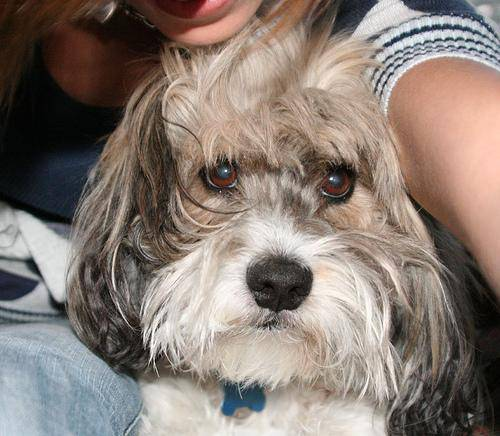

In [ ]:
# now if you wanted to access an image
Image(filename[900])

In [ ]:
labels['breed']

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [ ]:
breed_array = labels['breed']
breed_array = np.array(breed_array) #does the same thing as above
breed_array

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(breed_array)

10222

In [ ]:
#check if the number of labels and number of images are the same
if len(breed_array) == len(filename):
  print('The number of labels matches the number of images')
else:
  print('The number of labels does not matche the number of images, check data directory!')

The number of labels matches the number of images


In [ ]:
#find the unique labels
unique_breeds = np.unique(breed_array)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
#turn a single label into an array of booleans 
print(breed_array[0])
breed_array[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
#turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in breed_array]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
type(boolean_labels)

list

## Turning these boolean arrays into 0's and 1's


In [ ]:
#Lets do this with just 1 breed for now
print(breed_array[0]) #original label of the breed
print(np.where(unique_breeds == breed_array[0]))  #index where the label of the breed is located in the `unique_breeds` array
print(boolean_labels[0].argmax())                 #index where the label of the breed occurs in the `boolean_labels` list
print(boolean_labels[0].astype(int))              #convert boolean values to integers

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


#### `argmax()`
argmax() function returns indices of the max element of the array in a particular axis.

## Creating our own Validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own

In [ ]:
# Set up X & y
X = filename
y = boolean_labels


In [ ]:
len(X), len(y)

(10222, 10222)

#### We're starting off experimenting with ~1000 images and increase as needed 

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type : 'slider', min:1000, max:10000, step:1000}

In [ ]:
# let's split our data into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
                                                  X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

# Preprocessing Images (turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things: 
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like

In [ ]:
#Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filename[42])
image.shape # (length, width, RGB color channel)

(257, 350, 3)

In [ ]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [ ]:
# Turning it into Tensors
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [ ]:

image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

In [ ]:
# Define Image Size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  '''
  Takes an image file path and turns the image into a Tensor.
  '''

  # Read in an image
  image = tf.io.read_file(image_path)

  # Turn the jpeg into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the colour channel values from 0-255 to 0-1 (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)

  #Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

In [ ]:
# Create a simple function to return tuple (image, label)
def get_image_label(image_path, label):
  '''
  Takes an image file path name and the associated label,
  processes the image and returns a type of tuple - (image, label)
  '''
  image = process_image(image_path)
  return image, label

In [ ]:
#Demo of the above
(process_image(X[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form `(image, label)` . Let's make a function to turn all of our data `(X & y)` into batches

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  '''
  Creates batches of data out of image (X) & label (y) pairs
  Shuffles the data if it's training data but doesn't if it's validation data
  Also accepts test data as input(no labels).
  '''

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only filepaths, no labels
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating valid data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),      #filepaths
                                               tf.constant(y)))     #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else: 
    print('Creating training batches...')

    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),       #filepaths
                                              tf.constant(y)))       #labels

    #Shuffling pathnames and labels before mapping
    data = data.shuffle(buffer_size=len(X))

    #Create (image, label) tuples - this will also turn the image path into a preprocessed image
    data = data.map(get_image_label)

    #Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Create training & validation data batches

val_data = create_data_batches(X_val,y_val, valid_data=True)


Creating valid data batches...


In [ ]:
train_data = create_data_batches(X_train, y_train)

Creating training batches...


In [ ]:
# Check out different attributes of our data batches

train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))